In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CIFAR100
from torchvision import transforms

In [2]:
class CNNCifar100(nn.Module):
    def __init__(self):
        super(CNNCifar100, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),            # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),           # [batch, 24, 8, 8]
            nn.ReLU(),
			nn.Conv2d(24, 48, 4, stride=2, padding=1),           # [batch, 48, 4, 4]
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
			nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
            nn.ReLU(),
			nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),   # [batch, 3, 32, 32]
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [3]:
transform = transforms.Compose(
    [
        transforms.ToTensor(), 
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

trainset = CIFAR100(root='~/data',  train=True, download=True, transform=transform)
train_dl = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testset = CIFAR100(root='~/data', train=False, download=True, transform=transform)
test_dl = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

print(len(train_dl), len(test_dl))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 169001437/169001437 [00:46<00:00, 3615409.84it/s]


Extracting /home/khoidh/data/cifar-100-python.tar.gz to /home/khoidh/data
Files already downloaded and verified
782 157


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

epochs = 20

model = CNNCifar100().to(device)

optimizer = Adam(model.parameters(), lr = 0.001)

scheduler = CosineAnnealingLR(optimizer, epochs)

loss_fn = nn.MSELoss()

In [5]:
for epoch in range(epochs):
    model.train()
    tr_total_loss = 0
    for train_img, _ in tqdm(train_dl):
        train_img = train_img.to(device)

        gen_img = model(train_img)
        train_loss = loss_fn(gen_img, train_img)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        tr_total_loss += train_loss.item()

    model.eval()
    with torch.no_grad():
        va_total_loss = 0
        for valid_img, _ in tqdm(test_dl):
            valid_img = valid_img.to(device)

            gen_img = model(valid_img)

            valid_loss = loss_fn(gen_img, valid_img)

            va_total_loss += valid_loss.item()

    print(f"Epoch: {epoch} - TrainLoss: {tr_total_loss/len(train_dl)} - ValidLoss: {va_total_loss/len(test_dl)}")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 53.31it/s]


Epoch: 0 - TrainLoss: 0.20059326279651174 - ValidLoss: 0.17167175936091478


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 52.50it/s]


Epoch: 1 - TrainLoss: 0.16804019369356468 - ValidLoss: 0.16597236389187492


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 53.91it/s]


Epoch: 2 - TrainLoss: 0.16426803880487867 - ValidLoss: 0.16345257164946028


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 56.30it/s]


Epoch: 3 - TrainLoss: 0.16251588692826688 - ValidLoss: 0.1621209668695547


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:03<00:00, 52.04it/s]


Epoch: 4 - TrainLoss: 0.16128225519757747 - ValidLoss: 0.16064267463175355


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:03<00:00, 50.72it/s]


Epoch: 5 - TrainLoss: 0.15999285400371113 - ValidLoss: 0.1597152147798022


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 54.40it/s]


Epoch: 6 - TrainLoss: 0.15924024863926042 - ValidLoss: 0.15940259738712553


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:03<00:00, 48.46it/s]


Epoch: 7 - TrainLoss: 0.1587602329604766 - ValidLoss: 0.15919661180228944


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:03<00:00, 51.30it/s]


Epoch: 8 - TrainLoss: 0.15835387146343355 - ValidLoss: 0.158524262297685


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 52.64it/s]


Epoch: 9 - TrainLoss: 0.15811615914601804 - ValidLoss: 0.15827579402430042


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 52.92it/s]


Epoch: 10 - TrainLoss: 0.1579153094335895 - ValidLoss: 0.15806406617734084


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 54.24it/s]


Epoch: 11 - TrainLoss: 0.15772978953845665 - ValidLoss: 0.15777347137214273


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 54.22it/s]


Epoch: 12 - TrainLoss: 0.1575520987553365 - ValidLoss: 0.15770247521673797


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:03<00:00, 50.74it/s]


Epoch: 13 - TrainLoss: 0.15742021378920512 - ValidLoss: 0.15744731489829955


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 52.95it/s]


Epoch: 14 - TrainLoss: 0.15733114930103198 - ValidLoss: 0.15736375815549475


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 54.60it/s]


Epoch: 15 - TrainLoss: 0.15716281700926973 - ValidLoss: 0.15728550579897158


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 52.59it/s]


Epoch: 16 - TrainLoss: 0.15700547399994969 - ValidLoss: 0.15718991988024134


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 53.18it/s]


Epoch: 17 - TrainLoss: 0.15697143412650089 - ValidLoss: 0.15709084637795284


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 52.93it/s]


Epoch: 18 - TrainLoss: 0.15677319538524692 - ValidLoss: 0.15687537829207768


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 52.88it/s]

Epoch: 19 - TrainLoss: 0.15673387730899063 - ValidLoss: 0.15678052034727327


 10%|█████████████████▋                                                                                                                                                               | 1/10 [00:00<00:00,  9.54it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 30%|█████████████████████████████████████████████████████                                                                                                                            | 3/10 [00:00<00:00, 11.58it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 50%|████████████████████████████████████████████████████████████████████████████████████████▌                                        

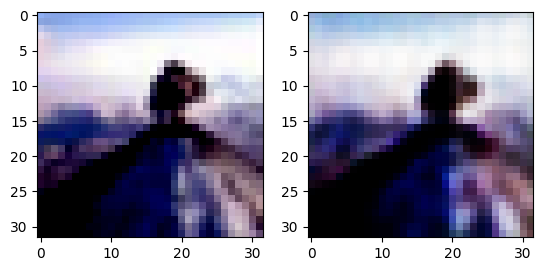

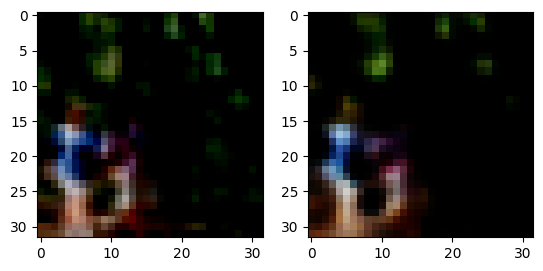

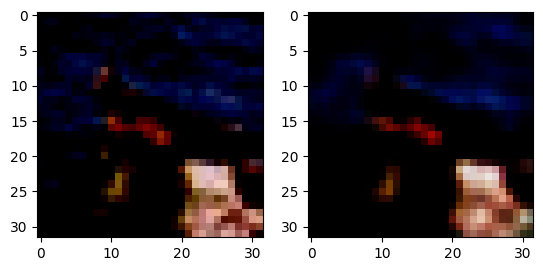

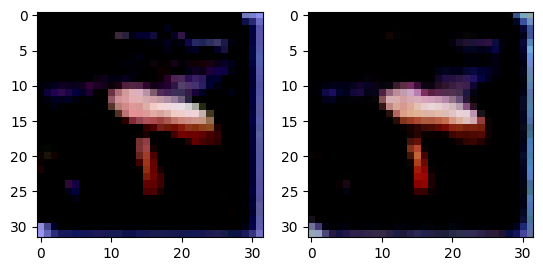

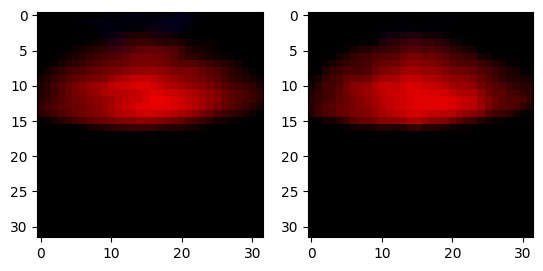

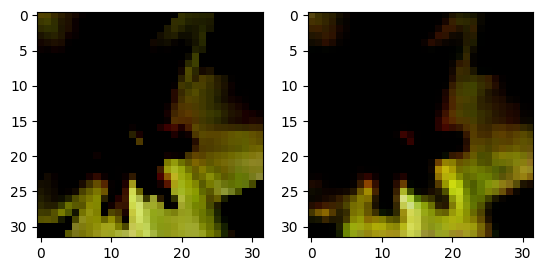

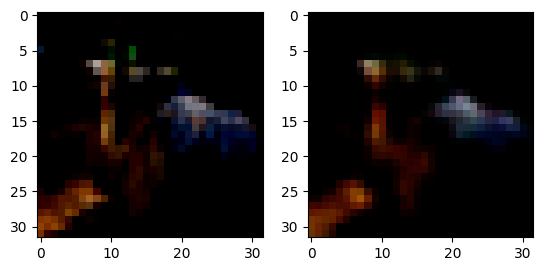

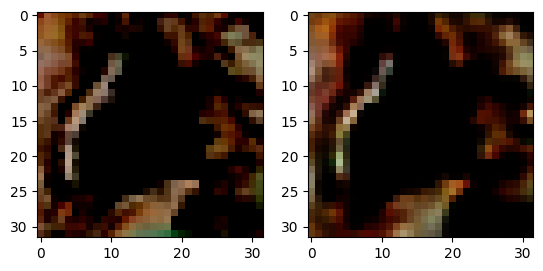

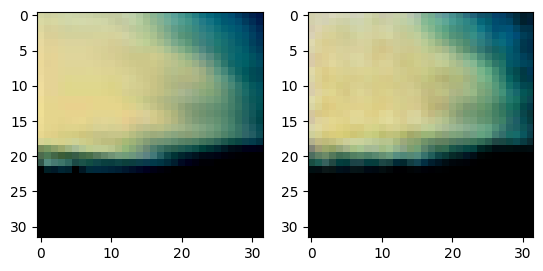

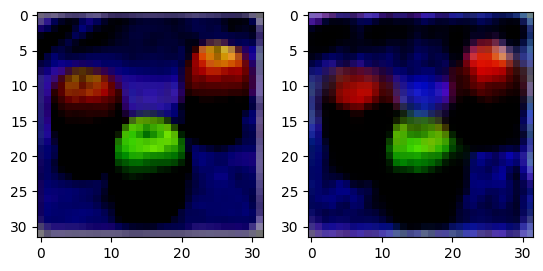

In [6]:
model.eval()
with torch.no_grad():
    for test_case_idx in tqdm(range(10)):
        valid_img, _ = testset[test_case_idx]
        valid_img = valid_img.unsqueeze(dim=0).to(device)

        gen_img = model(valid_img)        

        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(valid_img[0].cpu().permute(1, -1, 0).numpy())
        axarr[1].imshow(gen_img[0].cpu().permute(1, -1, 0).numpy())